# IGRINS GMTNIRS $76^{\circ}$ blaze model

LM3-10 maybe?

Here we finally get to our desired result: the blaze envelope at R3.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

%config InlineBackend.figure_format='retina'

### Fixed physical properties

In [2]:
sigma = 71.43 # micron

In [3]:
groove_top_width = 71.43 - 42.43 # micron

In [4]:
N_guesses = 20
blaze_angle_vector_degrees = np.linspace(75.0, 77.0, N_guesses) 
blaze_angle_vector_radians = np.radians(blaze_angle_vector_degrees) # radians
blaze_angle_vector_degrees

array([75.        , 75.10526316, 75.21052632, 75.31578947, 75.42105263,
       75.52631579, 75.63157895, 75.73684211, 75.84210526, 75.94736842,
       76.05263158, 76.15789474, 76.26315789, 76.36842105, 76.47368421,
       76.57894737, 76.68421053, 76.78947368, 76.89473684, 77.        ])

In [5]:
blaze_column = blaze_angle_vector_radians.reshape((1, N_guesses))

In [6]:
blaze_angle_degrees = 76.2
blaze_angle_radians = np.radians(blaze_angle_degrees) # radians
blaze_angle_degrees

76.2

Assume testing in back-surface reflection in visible light!

In [7]:
wavelength_micron = 0.6328 # micron

In [8]:
max_m = np.floor(2 * sigma / wavelength_micron)
m_vector = np.arange(-max_m, max_m+1, 1)

Note that we are including diffraction orders like $m=-52$ that only exist for some incidence angles.  That's OK! We are being overly-inclusive in case we go to extreme values of $\theta_i$ that reveal some of those presently-unphysical orders.

In [9]:
targetm = 219

In [10]:
theta_i_radians = np.arcsin((targetm*wavelength_micron)/(2*sigma))
theta_i_degrees = np.degrees(theta_i_radians)

In [11]:
theta_i_degrees

75.94498769048386

In [12]:
theta_m_radians = np.arcsin(np.sin(theta_i_radians) - m_vector*(wavelength_micron)/sigma)
theta_m_degrees = np.degrees(theta_m_radians)

/var/folders/gb/yvbtr8b57pd1nzzxk3t_zwfsxgvdgb/T/ipykernel_82543/107915029.py:1: RuntimeWarning: invalid value encountered in arcsin
  theta_m_radians = np.arcsin(np.sin(theta_i_radians) - m_vector*(wavelength_micron)/sigma)


In [13]:
finite_mask = np.isfinite(theta_m_radians)

In [14]:
def foreshortened_groove(sigma, groove_top_width, incidence_angle):
    """ The size of the illuminated groove 
    
    Note:
    -----
    Function formerly known as "beam_waist", renamed to disambiguate
    
    Parameters:
    -----------
    sigma: The groove spacing or groove pitch (micron)
    groove_top_width: The groove top or 'dam' unique to Si grating
        development, they cause shadowing (micron)
    incidence_angle: The input angle, as measured from the 
        grating normal (degrees)
    """
    
    A_micron = sigma - groove_top_width
    incidence_angle_radians = np.radians(incidence_angle)
    
    output = A_micron * np.cos(incidence_angle_radians)
    return output

In [15]:
d_term = foreshortened_groove(sigma, groove_top_width, theta_i_degrees)
d_term

10.304270162441153

In [16]:
blaze_modulation_at_order_peaks = np.sinc((d_term*np.pi/(wavelength_micron)*
                np.sin(theta_m_radians + blaze_angle_radians)))**2

In [17]:
blaze_flux_matrix = np.sinc((d_term*np.pi/(wavelength_micron)*
                np.sin(theta_m_radians + blaze_column.T)))**2

In [18]:
blaze_flux_matrix

array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])

In [19]:
blaze_flux_matrix.shape

(20, 451)

In [20]:
peak_indices = np.nanargmax(blaze_flux_matrix, axis=1)

In [22]:
m_vector[444]

219.0

(0.0, 3.0)

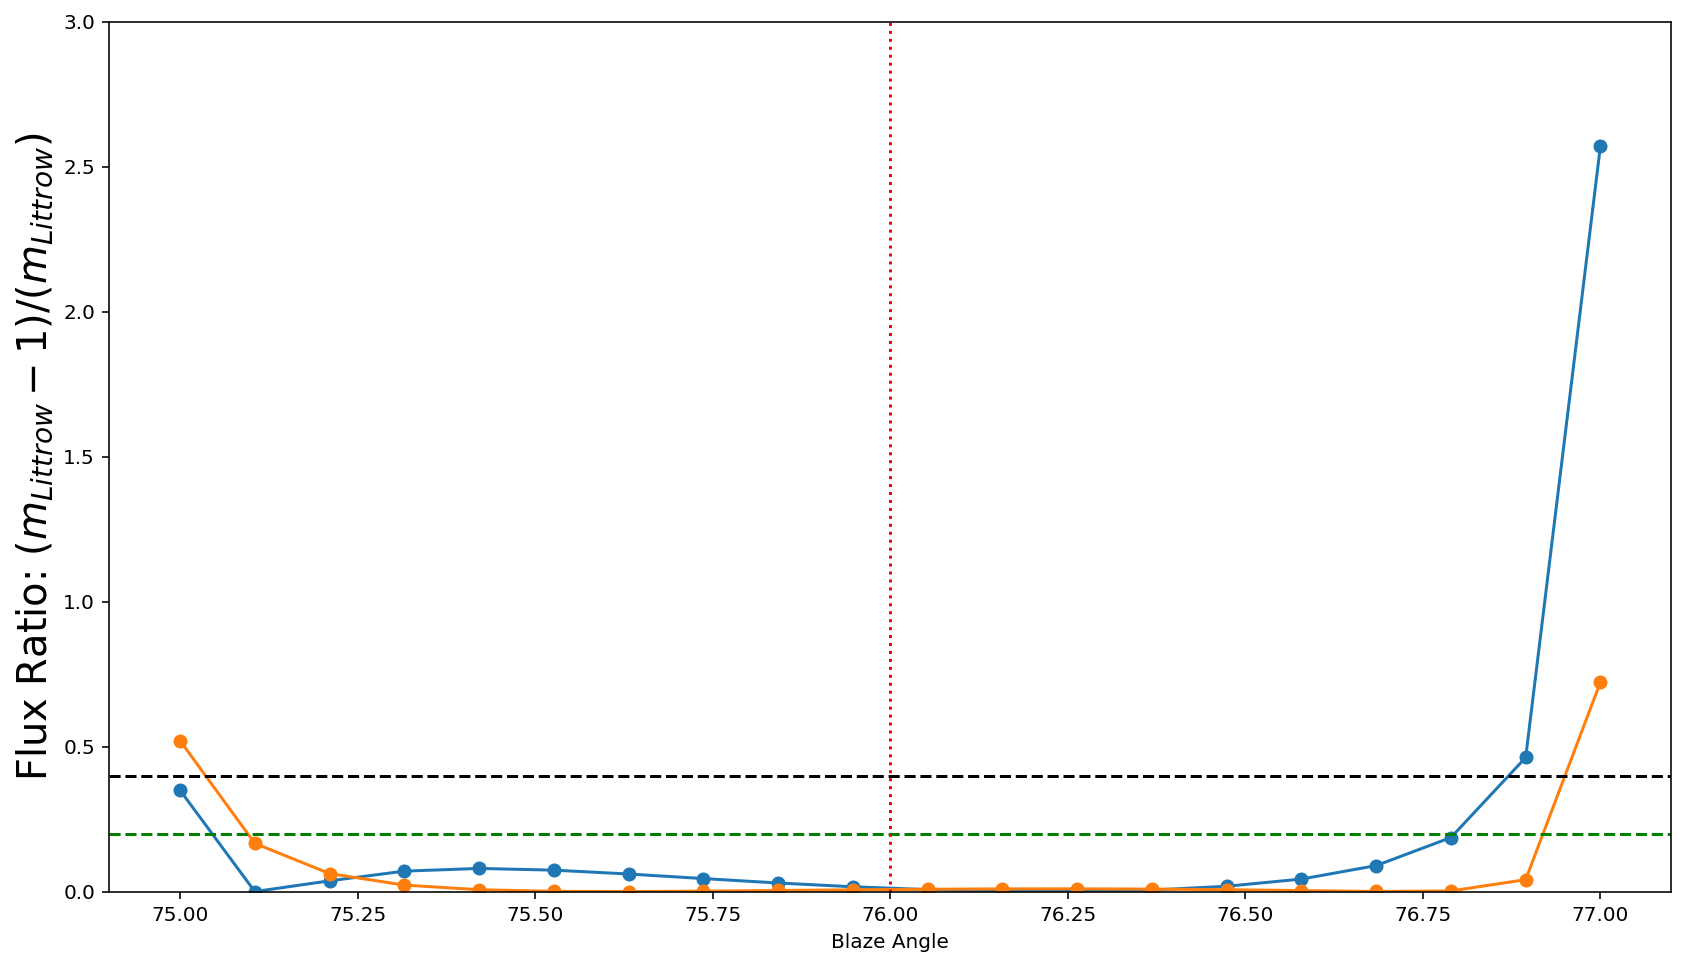

In [41]:
plt.figure(figsize=(14, 8))
plt.plot(blaze_angle_vector_degrees, blaze_flux_matrix[:, 443]/blaze_flux_matrix[:, 444], 'o-')
plt.plot(blaze_angle_vector_degrees, blaze_flux_matrix[:, 442]/blaze_flux_matrix[:, 444], 'o-')
plt.xlabel('Blaze Angle')
plt.ylabel('Flux Ratio: $(m_{Littrow}-1)/(m_{Littrow})$', fontsize=20)
plt.axhline(0.4, color='k', linestyle='dashed')
plt.axhline(0.2, color='g', linestyle='dashed')
plt.axvline(76, color='r', linestyle='dotted')
plt.ylim(0, 3)

In [25]:
lookup_dict = {'m':m_vector, 
               'theta_i_degrees':theta_i_degrees*(-1),
               'theta_m_degrees':theta_m_degrees, 
               'theta_m_radians':theta_m_radians,
               'unnormalized_flux':blaze_modulation_at_order_peaks,
               'normalize_flux':blaze_modulation_at_order_peaks
              }

In [26]:
df = pd.DataFrame(lookup_dict).dropna()

In [27]:
brightest_index = df.normalize_flux.argmax()

In [28]:
df.iloc[brightest_index-3:brightest_index+1]

,m,theta_i_degrees,theta_m_degrees,theta_m_radians,unnormalized_flux,normalize_flux
441,216.0,-75.944988,-70.645464,-1.232996,0.000095,0.000095
442,217.0,-75.944988,-72.240446,-1.260834,0.008036,0.008036
443,218.0,-75.944988,-73.988006,-1.291334,0.000167,0.000167
444,219.0,-75.944988,-75.944988,-1.325490,0.840668,0.840668


Again, there's an incidence-angle foreshortening effect here...